In [10]:
import json

In [11]:
with open('wiki_bio_gpt3_filtered.json', 'r') as file:
    # Read the content of the file
    wiki_bio_gpt3_filtered = json.load(file)
    
print(len(wiki_bio_gpt3_filtered))

238


In [12]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from scipy.spatial.distance import cosine

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Your existing functions here
def get_embedding(text, tokenizer, model):
    # Tokenize text and convert to input format
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Get embeddings from the model
    with torch.no_grad():
        outputs = model(**inputs)
    # Pool the outputs to get a single vector embedding (mean pooling)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings

def calculate_similarity_matrix(text_samples, tokenizer, model):
    # Generate embeddings for each text sample
    embeddings = [get_embedding(text, tokenizer, model).numpy() for text in text_samples]
    
    # Initialize similarity matrix
    n = len(embeddings)
    similarity_matrix = np.zeros((n, n))
    
    # Calculate pairwise cosine similarity
    for i in range(n):
        for j in range(i, n): # No need to calculate twice if i == j or for lower triangle
            if i == j:
                similarity_matrix[i, j] = 1 # Similarity with itself is 1
            else:
                sim = 1 - cosine(embeddings[i], embeddings[j])
                similarity_matrix[i, j] = sim
                similarity_matrix[j, i] = sim # Symmetric property
    
    return similarity_matrix

def process_text_samples(data, tokenizer, model):

    gpt3_text_sample_similarity_scores = []
    
    for item in data:
        # Consider only the first five samples
        gpt3_text_samples = item['gpt3_text_samples']
        wiki_bio_text = item['wiki_bio_text']
        # Calculate the similarity matrix for these samples
        similarity_matrix = calculate_similarity_matrix(gpt3_text_samples, tokenizer, model)
        # Mask the diagonal and calculate the average similarity
        mask = np.ones(similarity_matrix.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        average_similarity = round(np.mean(similarity_matrix[mask]), 2)
        gpt3_text_sample_similarity_scores.append(
            {"gpt3_text_samples": gpt3_text_samples,
             "wiki_bio_text": wiki_bio_text,
             "average_similarity_score": average_similarity})
        
    return gpt3_text_sample_similarity_scores   

In [13]:
wiki_bio_gpt3_with_similariy_scores = process_text_samples(wiki_bio_gpt3_filtered, tokenizer, model)

In [14]:
wiki_bio_gpt3_with_similariy_scores[0]

{'gpt3_text_samples': ['John Russell Reynolds (1 November 1829  – 11 March 1907) was an English lexicographer, editor and author. Born in London, he was the eldest son of the first Lord Ogmore, and was educated at Trinity College, Oxford, where he graduated B.A. in 1852 and became a Fellow in 1854. He was president of Magdalen Hall from 1864 to 1884, and from 1864 to 1883 was assistant-editor to the Oxford English Dictionary under James Murray. \n\nHe was a permanent contributor to The Saturday Review, and wrote several books about the House of Commons. He also compiled dictionaries of quotations and biographies and edited collections of newspaper articles. He had a particular interest in the works of Christian mystics, writing studies of the lives and works of Saints Augustine and Thomas à Kempis. For his edition of Thomas à Kempis\' "The Imitation of Christ", first published in 1875, he wrote a biographical introduction.',
  "John Russell Reynolds (26 April 1819 – 17 June 1879) was a

In [15]:
# For descending order sorting
wiki_bio_gpt3_with_similariy_scores_sorted = sorted(wiki_bio_gpt3_with_similariy_scores, key=lambda x: x['average_similarity_score'], reverse=True)
wiki_bio_gpt3_with_similariy_scores_sorted[0]

{'gpt3_text_samples': ["Katie Ledecky (born March 17, 1997) is an American competitive swimmer. She has broken several world records in distance freestyle and has won five Olympic gold medals and 15 world championship gold medals. Ledecky holds the world record in the women's 1500-, 800-, and 400-meter freestyle events. She also holds the fastest-ever times in the women's 1500-meter and 400-meter freestyle events.\n\nLedecky began swimming at the age of 6. She first achieved national prominence at the 2012 Olympics in London, where she won the gold medal, setting a new world record in the 800-meter freestyle. Since then, Ledecky has gone on to win multiple world championship and Olympic medals in the freestyle, medley, and open-water events. She is the current World and American Record holder for the 1500-meter freestyle, and the 400-meter freestyle.",
  "Katie Ledecky (born March 17, 1997) is an American competitive swimmer. She is the current world-record holder in the women's 400-me

In [16]:
def write_results_to_file(results, output_file):
    with open(output_file, "w") as json_file:
         json.dump(results, json_file)
    print(f"Results have been saved to {output_file}")
    
write_results_to_file(wiki_bio_gpt3_with_similariy_scores_sorted, "wiki_bio_gpt3_with_similariy_scores.json")

Results have been saved to wiki_bio_gpt3_with_similariy_scores.json


In [17]:
# Separating the elements based on their average_similarity_score
less_or_equal_05_list = [item for item in wiki_bio_gpt3_with_similariy_scores if item['average_similarity_score'] <= 0.5]
greater_than_05_list = [item for item in wiki_bio_gpt3_with_similariy_scores if item['average_similarity_score'] > 0.5]

len(less_or_equal_05_list), len(greater_than_05_list)

(28, 210)

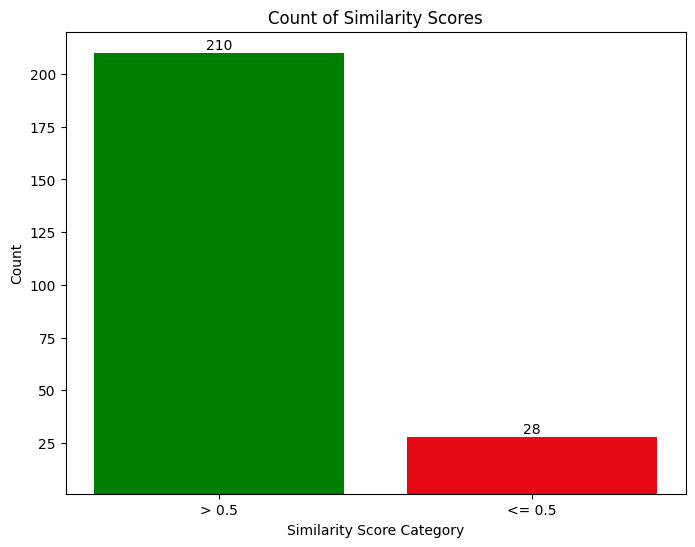

In [18]:
import matplotlib.pyplot as plt

# Labels and values for your data
labels = ['> 0.5', '<= 0.5']
values = [len(greater_than_05_list), len(less_or_equal_05_list)]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['green', '#E50914'])  # Corrected variable names

# Adding count labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')  # Ensure yval is integer

plt.title('Count of Similarity Scores')
plt.xlabel('Similarity Score Category')
plt.ylabel('Count')
plt.xticks(labels)
plt.ylim(1, max(values) + 10)  # Adjust y-axis to start from 1
plt.show()

In [19]:
similarity_matrix_1 = calculate_similarity_matrix(wiki_bio_gpt3_filtered[0]['gpt3_text_samples'],tokenizer, model)

In [20]:
wiki_bio_gpt3_filtered[0]['gpt3_text_samples']

['John Russell Reynolds (1 November 1829  – 11 March 1907) was an English lexicographer, editor and author. Born in London, he was the eldest son of the first Lord Ogmore, and was educated at Trinity College, Oxford, where he graduated B.A. in 1852 and became a Fellow in 1854. He was president of Magdalen Hall from 1864 to 1884, and from 1864 to 1883 was assistant-editor to the Oxford English Dictionary under James Murray. \n\nHe was a permanent contributor to The Saturday Review, and wrote several books about the House of Commons. He also compiled dictionaries of quotations and biographies and edited collections of newspaper articles. He had a particular interest in the works of Christian mystics, writing studies of the lives and works of Saints Augustine and Thomas à Kempis. For his edition of Thomas à Kempis\' "The Imitation of Christ", first published in 1875, he wrote a biographical introduction.',
 "John Russell Reynolds (26 April 1819 – 17 June 1879) was an English poet, journal

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

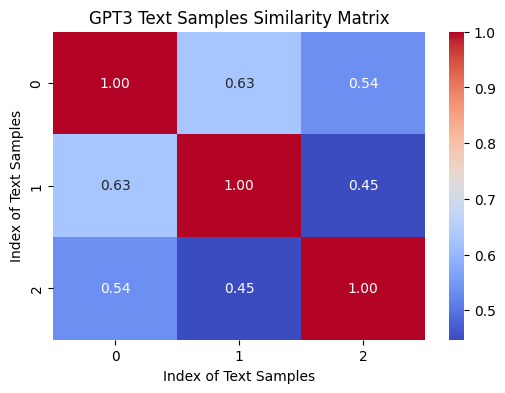

In [22]:
plt.figure(figsize=(6, 4)) # Adjust the size as per your requirement
sns.heatmap(similarity_matrix_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('GPT3 Text Samples Similarity Matrix')
plt.xlabel('Index of Text Samples')
plt.ylabel('Index of Text Samples')
plt.show()